## This Notebook Uses The Amazon Reviews Dataset And Predict Whether The Review Is Positive Or Negative

Source of data = https://www.kaggle.com/snap/amazon-fine-food-reviews 

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.sparse as mat
import warnings
warnings.filterwarnings("ignore")
import scipy.stats
from gensim.models import Word2Vec, KeyedVectors
from IPython.display import HTML,display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
!pip install eli5

In [3]:
import eli5

In [4]:
data = pd.read_csv("Reviews.csv")

In [5]:
data = data[data.Score!=3]

In [6]:
type(data)

pandas.core.frame.DataFrame

In [7]:
data.shape

(525814, 10)

In [8]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
data = data[:20000]

In [10]:
data['ProductId'].nunique()

2715

In [11]:
data['UserId'].nunique()

17788

In [12]:
# To predict the polarity of review, we have to use the scores provided in the data and hence we will convert the score
# into binary values
def Classifier(x):
    if x<3:
        return 0
    return 1
data['Score']=data['Score'].map(Classifier)

In [13]:
data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [14]:
final_data = data.drop_duplicates(subset = ['UserId','ProfileName','Time','Text'])

In [15]:
final_data = final_data.dropna()

In [16]:
final_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


What I find now is that there are 2 rows of data where helpfulness denominator is greater than numerator in my 5000 rows

In [17]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]

In [18]:
final_data['Score'].value_counts(normalize = True)

1    0.844218
0    0.155782
Name: Score, dtype: float64

84% of the reviews are positive, and 16% are negative.

#### Adding another feature - length of text of review

In [19]:
len_rev =[len(i) for i in final_data['Text']]
print(len(len_rev))

19354


#### Sorting according to time, so that we can do time-based split

In [20]:
# sorting the data by time, so that we can do timebased splitting.
final_data.sort_values('Time',inplace=True,ascending=True)

In [21]:
final_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...


In [22]:
final_data.Text[443]  # after randomly reading the reviews, i saw that the reviews had many tags.

"What I like about them:<br />1) Very thick chips.<br />2) No trans fat and all natural, according to the info on the bag.<br />3) Flavor, but that's a subjective thing.<br />4) 2oz bags, which keep you from eating too much at one time. Just set a limit of 1 bag.<br /><br />Cons:<br />As another reviewer said, there's a lot of oil in them chips. What I do is place a paper napkin on a plate and pour the chips on them. Wait a few mins before eating and the napkin will soak some of the oil off. It seems gross that there is so much oil on the chip that a napkin will soak it off, but it's true! And at least this way, you'll get rid of some of the oil."

In [23]:
final_data.shape

(19354, 10)

## Preprocessing the text

All the credits to AAIC team for wonderful course.
1. Begin by removing the html tags, we will use beautiful soup for this.
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Wordnet lemmatizer as it is better than snowball stemmer

In [24]:
# importing the libraries needed
import re
import nltk
import string
from bs4 import BeautifulSoup
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to C:\Users\Akash
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Akash
[nltk_data]     Jain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stopword = nltk.corpus.stopwords.words('english')


In [26]:
lemm = nltk.stem.wordnet.WordNetLemmatizer()
stemm = nltk.stem.SnowballStemmer('english')

In [27]:
#this is how the lemmatizer works
lemm.lemmatize('communities')

'community'

In [28]:
stemm.stem('communities')

'communiti'

In [29]:
stopword = set(stopword)

We will use lemmatizer as it makes use of dictionary and is good for our problem

###  preprocessing the text

In [30]:
def cleaner(phrase):
    # decontraction
        #removing words with numbers and special characters
    phrase =  re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)","",str(phrase))
    phrase = re.sub(r"\d\S","", phrase)
    phrase = re.sub(r"\S*\d\S","", phrase).strip()
    phrase = re.sub(r"[^A-Za-z0-9]+"," ",phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)  # r means raw string
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

In [31]:
from tqdm import tqdm
cleaned_text = []
words = []
for sent in tqdm(final_data['Text'].values):
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = cleaner(sent)
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_text.append(sent)

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:18<00:00, 1051.89it/s]


In [32]:
from tqdm import tqdm
cleaned_summary = []

for sent in tqdm(final_data['Summary'].values):
    sent = cleaner(sent)
    sent = BeautifulSoup(sent,'lxml').get_text()
    sent = ' '.join(e.lower() for e in sent.split() if e.lower() not in stopword)
    sent = ' '.join(lemm.lemmatize(e) for e in sent.split())
    cleaned_summary.append(sent)

100%|██████████████████████████████████████████████████████████████████████████| 19354/19354 [00:08<00:00, 2169.42it/s]


In [33]:
#creating new dataframe to increase our features
d = {
    'text':cleaned_text,
    'summary':cleaned_summary,
    'length':len_rev
}

In [34]:
df1 = pd.DataFrame(d)

In [35]:
df1['text+summary'] = df1['text'].map(str)+df1['summary']

In [36]:
df1 = df1.drop(columns = ['text','summary'])

####  Functions That We Will Use For LInear SVM

In [37]:
def finding_right_param_model(xtrain,ytrain,xcross,ycross,penalty_value = '',classifier = ''):
    roc_cv1 = []
    roc_tr1 = []
    alpha_values = [0.001,0.1,1,10,100]
    for i in tqdm(alpha_values):
        if classifier == 'rbf':
            clf = SVC(C = i,probability=True)
            
        else:
            sgd = SGDClassifier(alpha = i,penalty=penalty_value)


            #doing the 3-fold cross validation using grid search to find the right alpha
            clf = CalibratedClassifierCV(sgd,cv = 3)
        
        clf.fit(xtrain,ytrain)
        # predict the response on the crossvalidation train
        pred = clf.predict_proba(xcross)[:,1]
        pred1 = clf.predict_proba(xtrain)[:,1]

        #ROC_AUC SCORE
        roc_cv= roc_auc_score(ycross,pred)
        roc_cv1.append(roc_cv)
        roc_tr =roc_auc_score(ytrain,pred1)
        roc_tr1.append(roc_tr)

    #plotting the roc-auc
    plot1= plt.subplot(1,1,1)
    plt.grid()
    plt.title("Area Under Roc Curve for Train and Cv Data")
    plt.plot(alpha_values,roc_cv1,label="roc_auc_cv")
    plt.plot(alpha_values,roc_tr1,label ="roc_auc_tr")
    plt.xlabel('ALPHA')
    plt.ylabel('Area under curve of ROC')
    plt.legend()
    plt.show()

In [38]:
def final_model(xtrain,ytrain,xtestdata,ytestdata,penalty_value = '',param_value = '',vect_type ='',classifier = ''):
    # Training the model with the right parameter
    if classifier == 'rbf':
        clf = SVC(C = param_value)

    else:
        sgd = SGDClassifier(alpha = param_value,penalty=penalty_value)
        sgd.fit(xtrain,ytrain)
        clf = CalibratedClassifierCV(sgd)
        
    clf.fit(xtrain,ytrain)
        # predict the response 
    pred = clf.predict_proba(xtestdata)[:,1]
    pred1 = clf.predict_proba(xtrain)[:,1]
    #plotting the roc 
    final_auc_score= roc_auc_score(ytestdata,pred)
    print("*******Final Auc Score is {}*********".format(final_auc_score))
    
    print("**********Important Features are******************")
    if classifier == 'rbf':
        display(HTML(eli5.show_weights(clf, vec=vect_type, top=15 ,target_names=ytestdata).data))
    else:
        display(HTML(eli5.show_weights(sgd, vec=vect_type, top=15 ,target_names=ytestdata).data))
    #Plotting the roc-curve
    fpr,tpr,threshold = roc_curve(ytestdata,pred)
    fpr1,tpr1,threshold1 = roc_curve(ytrain,pred1)
    plt.figure(2,figsize = (15,4))
    plt.subplot(1,2,1)
    plt.title("Roc Curve For Train and Test Data")
    plt.plot(fpr,tpr,label = "test-roc")
    plt.plot(fpr1,tpr1,label = "train-roc")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    #plotting the confusion matrix
    plt.subplot(1,2,2)
    cm = confusion_matrix(ytestdata,clf.predict(xtestdata))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d",center =None)
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()


### Text Featurization

#### BAG OF WORDS

In [39]:
df1.shape

(19354, 2)

In [40]:
# splitting the dataframe into train,test,cv dataset 
from sklearn.model_selection import train_test_split as splitter
x,xtest,y,ytest = splitter(df1,final_data['Score'],test_size = 0.2)
xtr,xcv,ytr,ycv = splitter(x,y,test_size=0.2)

In [41]:
#Using Bag of words on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
bow = textfeat.CountVectorizer()
bow.fit(xtr['text+summary'])
bow_xtr= bow.transform(xtr['text+summary'])
bow_xcv = bow.transform(xcv['text+summary'])
bow_xtest = bow.transform(xtest['text+summary'])

In [42]:
bow_xcv.shape

(3097, 29555)

In [43]:
bow_xtr.shape

(12386, 29555)

In [44]:
bow_with_other_features_train = mat.hstack([bow_xtr,np.array(xtr['length']).reshape(xtr.shape[0],1)]) # reshaping
bow_with_other_features_cv = mat.hstack([bow_xcv,np.array(xcv['length']).reshape(xcv.shape[0],1)])
bow_with_other_features_test = mat.hstack([bow_xtest,np.array(xtest['length']).reshape(xtest.shape[0],1)])

In [45]:
bow_with_other_features_cv.shape

(3097, 29556)

In [46]:
type(bow_with_other_features_train)

scipy.sparse.coo.coo_matrix

#### Applying Machine Learning Models

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.14it/s]


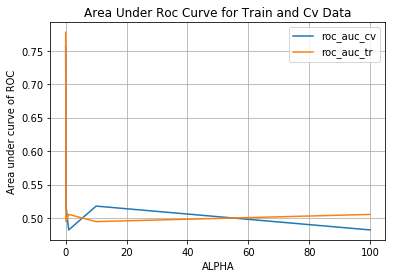

In [47]:
#L1 regularization
finding_right_param_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv,penalty_value='l1')

*******Final Auc Score is 0.5187606386100839*********
**********Important Features are******************


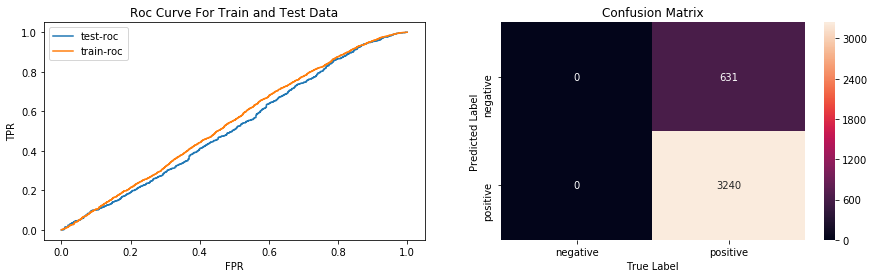

In [48]:
# As we can see that c = 0.0001 is the right alpha for us in bow
final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,penalty_value='l1',\
           param_value=0.0001,vect_type=bow)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.37it/s]


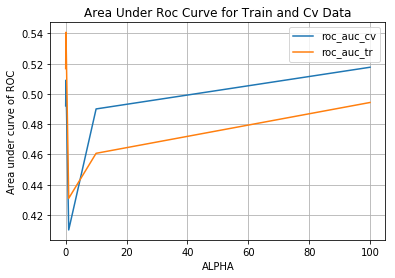

In [49]:
#L2 regularization
finding_right_param_model(bow_with_other_features_train,ytr,bow_with_other_features_cv,ycv,penalty_value='l2')

*******Final Auc Score is 0.49271732112461114*********
**********Important Features are******************


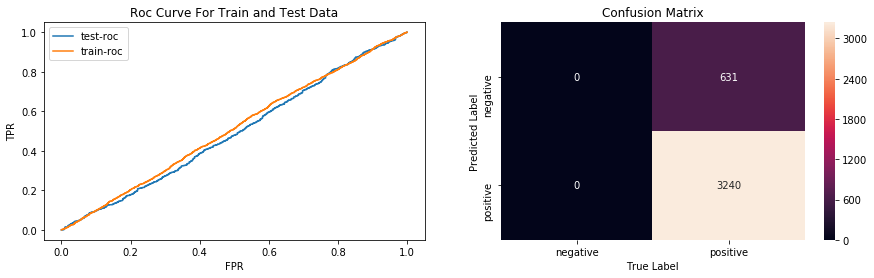

In [50]:
# As we can see that c = 0.0001 is the right alpha for us in bow
final_model(bow_with_other_features_train,ytr,bow_with_other_features_test,ytest,penalty_value='l2',\
           param_value=0.001,vect_type=bow)

In [51]:
# splitting the dataframe into train,test,cv dataset 
from sklearn.model_selection import train_test_split as splitter
x_,xtest_,y_,ytest_ = splitter(df1[:10000],final_data['Score'][:10000],test_size = 0.2)
xtr_,xcv_,ytr_,ycv_ = splitter(x,y,test_size=0.2)

In [52]:
#RBF Kernel

"""bow = textfeat.CountVectorizer(min_df = 10,max_features = 500)
bow.fit(xtr_['text+summary'])
bow_xtr= bow.transform(xtr_['text+summary'])
bow_xcv = bow.transform(xcv_['text+summary'])
bow_xtest = bow.transform(xtest_['text+summary'])
bow_with_other_features_train = mat.hstack([bow_xtr,np.array(xtr_['length']).reshape(xtr_.shape[0],1)]) # reshaping
bow_with_other_features_cv = mat.hstack([bow_xcv,np.array(xcv_['length']).reshape(xcv_.shape[0],1)])
bow_with_other_features_test = mat.hstack([bow_xtest,np.array(xtest_['length']).reshape(xtest_.shape[0],1)])"""

In [53]:
#finding_right_param_model(bow_with_other_features_train,ytr_,bow_with_other_features_cv,ycv_,classifier = 'rbf')

In [54]:
## final_model(bow_with_other_features_train,ytr_,bow_with_other_features_test,ytest_,classifier = 'rbf',\
#          param_value=0.0001,vect_type=bow)

### Term Frequency Inverse Document Frequency

In [55]:
#Using Tfidf on text and summary and adding another feature
import sklearn.feature_extraction.text as textfeat
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf.fit(xtr['text+summary'])
tfidf_xtr= tfidf.transform(xtr['text+summary'])
tfidf_xcv = tfidf.transform(xcv['text+summary'])
tfidf_xtest = tfidf.transform(xtest['text+summary'])

In [56]:
tfidf_with_other_features_train = mat.hstack([tfidf_xtr,np.array(xtr['length']).reshape(xtr.shape[0],1)]) # reshaping
tfidf_with_other_features_cv = mat.hstack([tfidf_xcv,np.array(xcv['length']).reshape(xcv.shape[0],1)])
tfidf_with_other_features_test = mat.hstack([tfidf_xtest,np.array(xtest['length']).reshape(xtest.shape[0],1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]


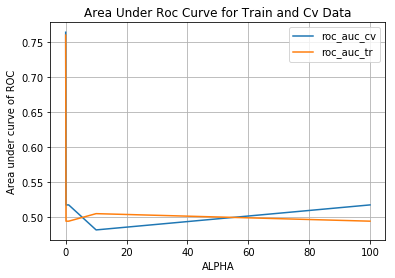

In [57]:
#L1 regularization
finding_right_param_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_cv,ycv,penalty_value='l1')

In [ ]:
# As we can see that c = 1 is the right alpha for us in bow
final_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_test,ytest,penalty_value='l1',\
           param_value=0.001,vect_type=tfidf)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.95it/s]


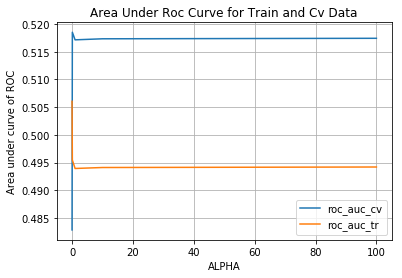

In [59]:
#L2 regularization
finding_right_param_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_cv,ycv,penalty_value='l2')

In [60]:
# As we can see that c = 2 is the right alpha for us in bow
#final_model(tfidf_with_other_features_train,ytr,tfidf_with_other_features_test,ytest,penalty_value='l2',\
 #           param_value=2,vect_type=tfidf)

In [61]:
"""#RBF kernel
import sklearn.feature_extraction.text as textfeat
tfidf = textfeat.TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features = 500)
tfidf.fit(xtr_['text+summary'])
tfidf_xtr= tfidf.transform(xtr_['text+summary'])
tfidf_xcv = tfidf.transform(xcv_['text+summary'])
tfidf_xtest = tfidf.transform(xtest_['text+summary'])

tfidf_with_other_features_train = mat.hstack([tfidf_xtr,np.array(xtr_['length']).reshape(xtr_.shape[0],1)]) # reshaping
tfidf_with_other_features_cv = mat.hstack([tfidf_xcv,np.array(xcv_['length']).reshape(xcv_.shape[0],1)])
tfidf_with_other_features_test = mat.hstack([tfidf_xtest,np.array(xtest_['length']).reshape(xtest_.shape[0],1)])"""

"#RBF kernel\nimport sklearn.feature_extraction.text as textfeat\ntfidf = textfeat.TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features = 500)\ntfidf.fit(xtr_['text+summary'])\ntfidf_xtr= tfidf.transform(xtr_['text+summary'])\ntfidf_xcv = tfidf.transform(xcv_['text+summary'])\ntfidf_xtest = tfidf.transform(xtest_['text+summary'])\n\ntfidf_with_other_features_train = mat.hstack([tfidf_xtr,np.array(xtr_['length']).reshape(xtr_.shape[0],1)]) # reshaping\ntfidf_with_other_features_cv = mat.hstack([tfidf_xcv,np.array(xcv_['length']).reshape(xcv_.shape[0],1)])\ntfidf_with_other_features_test = mat.hstack([tfidf_xtest,np.array(xtest_['length']).reshape(xtest_.shape[0],1)])"

In [62]:
#finding_right_param_model(tfidf_with_other_features_train,ytr_,tfidf_with_other_features_cv,ycv_,classifier = 'rbf')

In [63]:
#final_model(tfidf_with_other_features_train,ytr_,tfidf_with_other_features_test,ytest_,classifier = 'rbf',\
 #           param_value=2,vect_type=tfidf)

### AVG W2V

In [64]:
word_2_vec = Word2Vec(xtr['text+summary'],size= 40,min_count=4,workers=4)

In [65]:
xtr_vec = []
for sentence in tqdm(xtr['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xtr_vec.append(sen_vec)

100%|███████████████████████████████████████████████████████████████████████████| 12386/12386 [00:44<00:00, 280.52it/s]


In [66]:
xcv_vec = []
for sentence in tqdm(xcv['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xcv_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 3097/3097 [00:11<00:00, 266.03it/s]


In [67]:
xtest_vec = []
for sentence in tqdm(xtest['text+summary']):
    word_vec = np.zeros(40)
    cnt_words = 0
    for wor in sentence:
        if wor in word_2_vec:
            wor_vec = word_2_vec.wv[wor]
            word_vec = word_vec+wor_vec
            cnt_words += 1
    if cnt_words != 0:
        sen_vec = word_vec/cnt_words
    xtest_vec.append(sen_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 3871/3871 [00:12<00:00, 322.45it/s]


In [68]:
w2v_with_other_features_train = mat.hstack([np.array(xtr_vec),np.array(xtr['length']).resize(xtr.shape[0],1)]) # reshaping
w2v_with_other_features_cv = mat.hstack([np.array(xcv_vec),np.array(xcv['length']).resize(xcv.shape[0],1)])
w2v_with_other_features_test = mat.hstack([np.array(xtest_vec),np.array(xtest['length']).resize(xtest.shape[0],1)])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.54it/s]


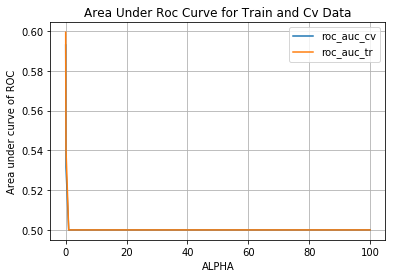

In [69]:
#L1 regularization
finding_right_param_model(w2v_with_other_features_train,ytr,w2v_with_other_features_cv,ycv,penalty_value='l1')

In [ ]:
# As we can see that c = 1 is the right alpha for us in bow
final_model(w2v_with_other_features_train,ytr,w2v_with_other_features_test,ytest,penalty_value='l1',\
            param_value=0.01)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]


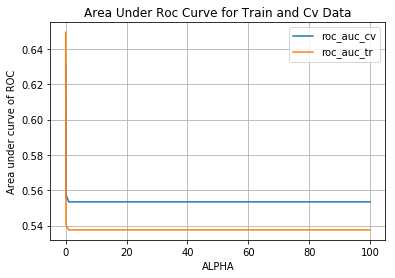

In [71]:
#L2 regularization
finding_right_param_model(w2v_with_other_features_train,ytr,w2v_with_other_features_cv,ycv,penalty_value='l2')

In [72]:
# As we can see that c = 2 is the right alpha for us in bow
#final_model(w2v_with_other_features_train,ytr,w2v_with_other_features_test,ytest,penalty_value='l2',\
 #           param_value=2)

In [73]:
#RBF kernel
#finding_right_param_model(w2v_with_other_features_train,ytr,w2v_with_other_features_cv,ycv,classifier = 'rbf')

In [74]:
# As we can see that c = 2 is the right alpha for us in bow
#final_model(w2v_with_other_features_train,ytr,w2v_with_other_features_test,ytest,classifier = 'rbf'\
 #           param_value=2)

### TFIDF-w2v

In [77]:
"""model = textfeat.TfidfVectorizer()
tf_idf_matrix = model.fit_transform(cleaned_text)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xtr['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)


tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xcv['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
            #  tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(xtest['text+summary']): # for each review/sentence 
    sent_vec = np.zeros(40) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in word_2_vec and word in tfidf_feat:
            vec = word_2_vec.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
"""

"model = textfeat.TfidfVectorizer()\ntf_idf_matrix = model.fit_transform(cleaned_text)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary = dict(zip(model.get_feature_names(), list(model.idf_)))\n\n# TF-IDF weighted Word2Vec\ntfidf_feat = model.get_feature_names() # tfidf words/col-names\n# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf\n\ntfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list\nfor sent in tqdm(xtr['text+summary']): # for each review/sentence \n    sent_vec = np.zeros(40) # as word vectors are of zero length\n    weight_sum =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in word_2_vec and word in tfidf_feat:\n            vec = word_2_vec.wv[word]\n#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]\n            # to reduce the computation we are \n     

In [ ]:
"""tfidf_w2v_with_other_features_train = mat.hstack([np.array(tfidf_sent_vectors_train),np.array(xtr['length'])\
                                                  .resize(xtr.shape[0],1)])
tfidf_w2v_with_other_features_cv = mat.hstack([np.array(tfidf_sent_vectors_cv),np.array(xcv['length']).resize(xcv.shape[0],1)])
tfidf_w2v_with_other_features_test = mat.hstack([np.array(tfidf_sent_vectors_test),np.array(xtest['length']).\
                                                 resize(xtest.shape[0],1)])"""

In [ ]:
#L1 regularization
#finding_right_param_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_cv,ycv,penalty_value='l1')

In [ ]:
# As we can see that c = 0.01 is the right alpha for us in bow
#final_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_test,ytest,penalty_value='l1',\
            param_value=0.1)

In [ ]:
#L2 regularization
#finding_right_param_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_cv,ycv,penalty_value='l2')

In [ ]:
# As we can see that c = 0.01 is the right alpha for us in bow
#final_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_test,ytest,penalty_value='l2',\
 #           param_value=0.1)""

In [ ]:
#RBF kernel
#finding_right_param_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_cv,ycv,classifier = 'rbf')

In [ ]:
# As we can see that c = 0.01 is the right alpha for us in bow
#final_model(tfidf_w2v_with_other_features_train,ytr,tfidf_w2v_with_other_features_test,ytest,classifier = 'rbf',\
 #           param_value=0.1)

### Conclusion

In [ ]:
Performs really good on large dataset